In [198]:
import soundfile as sf
import matplotlib.pyplot as plt
import sounddevice as sd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import find_peaks
from code_exercise1 import my_windowing, get_index_from_time, get_input_split_size, get_fundamental_frequency
from code_exercise2 import convert_to_samples, compute_stft, plot_spectrogram

threshold = 130
def load_audio(file_path: str) -> [np.ndarray, int]:
    """
    Load an audio file.

    :param file_path: path to the audio file
    :return: a tuple containing
        - the audio data
        - the sampling rate
    """
    return sf.read(file_path)
def compute_power(signal_segment: np.ndarray) -> float:
    """
    Compute the power of a signal segment.

    :param signal_segment: the signal segment
    :return: the power of the signal segment
    """
    return np.sum(signal_segment**2)/len(signal_segment)

def compute_power_for_all_frames(m_frames: np.ndarray) -> np.ndarray:
    """
    Compute the power for all frames.

    :param m_frames: matrix containing the frames
    :return: a vector containing the power for all frames
    """
    return np.apply_along_axis(compute_power, 1, m_frames)

def count_zero_crossings(signal_segment: np.ndarray) -> np.ndarray:
    """
    Count the zero crossings in a signal segment.

    :param signal_segment: the signal segment
    :return: the number of zero crossings
    """
    return np.sum(np.where(signal_segment*np.roll(signal_segment, 1)<=0, 1, 0))

def is_voiced(signal_segments: np.ndarray) -> np.ndarray:
    """
    Check if a signal segment is voiced.

    :param signal_segment: the signal segment
    :return: 1 if the signal segment is voiced, 0 otherwise
    """

    return get_number_of_zero_crossings(signal_segments) < threshold

def get_number_of_zero_crossings(signal) -> np.ndarray:
    """
    Get the number of zero crossings for all frames.

    :param signal: the signal
    :return: a vector containing the number of zero crossings for all frames
    """
    return np.apply_along_axis(count_zero_crossings, 1, signal)

    


In [199]:
# 2.2.1
x, fs = load_audio('Audio/female8khz.wav')
N = 32
R = 8 #segment shift
L = N - R 
m_frames, v_time_frame = my_windowing(x, fs, N, R)
# Why do we segment the signal prior to analysis instead of processing the whole signal at once?
# -> more detailed: we want to detect the different vowels and consonants in the signal in time
# -> analyzing bigger segments needs more frequencies -> more data -> more computation time
# Is a segment length of 32 ms appropriate? Why or why not?
# -> convert_to_samples(32, fs) = 256 sampels 
# -> tradeoff between time resolution and frequency resolution


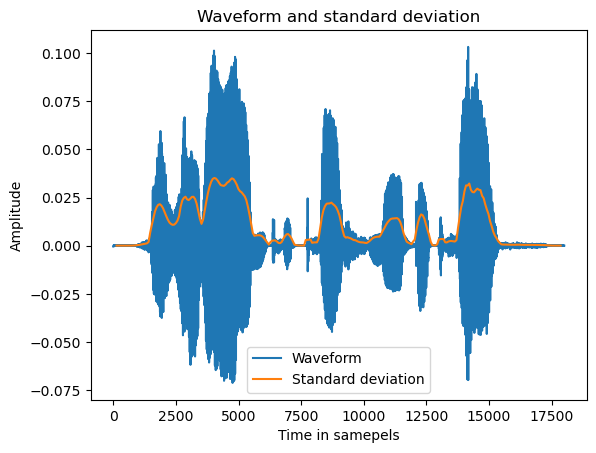

<Figure size 640x480 with 0 Axes>

In [200]:
# 2.2.2
# Compute the power of each frame
v_power = compute_power_for_all_frames(m_frames)
# standrad deviation
v_std = np.sqrt(v_power)
# plot waveform and v_std
plt.plot(x, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), v_std, label='Standard deviation')
plt.title('Waveform and standard deviation')
plt.xlabel('Time in samepels')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
plt.clf()

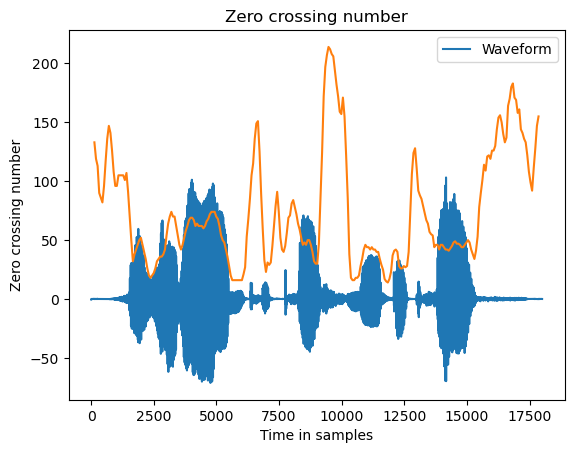

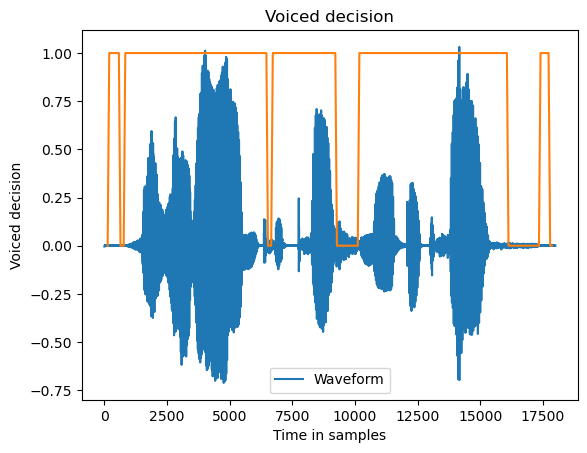

<Figure size 640x480 with 0 Axes>

In [201]:
# 2.2.3
# Explain differences in the creation of speech for voiced and unvoiced sounds.
# -> voiced sounds: vocal cords vibrate -> periodic signal, unvoiced sounds: turbulent airflow -> aperiodic signal aka noise (more zero crossings)
# Why might the number of zero crossings provide valuable information for the voiced/unvoiced decision?
# -> voiced sounds: less zero crossings, unvoiced sounds: more zero crossings
# Think of a way how you can efficiently detect a zero crossing between two samples. How can you realize that in Python?
# -> sample[i] * sample[i+1] < 0 oder ein schritt in der auto correlation: np.sum(np.sign(sample* sample.shift(1)))

zero_crossing_number = get_number_of_zero_crossings(m_frames)
plt.plot(x*1000, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), zero_crossing_number)
plt.title('Zero crossing number')
plt.xlabel('Time in samples')
plt.ylabel('Zero crossing number')
plt.legend()
plt.show()
plt.clf()

# we threshold around 80 zero crossings

voiced_decision = is_voiced(m_frames)
plt.plot(x*10, label='Waveform')
plt.plot(get_index_from_time(v_time_frame/1000, fs), voiced_decision)
plt.title('Voiced decision')
plt.xlabel('Time in samples')
plt.ylabel('Voiced decision')
plt.legend()
plt.show()
plt.clf()

# In general: are all speech sounds eit2

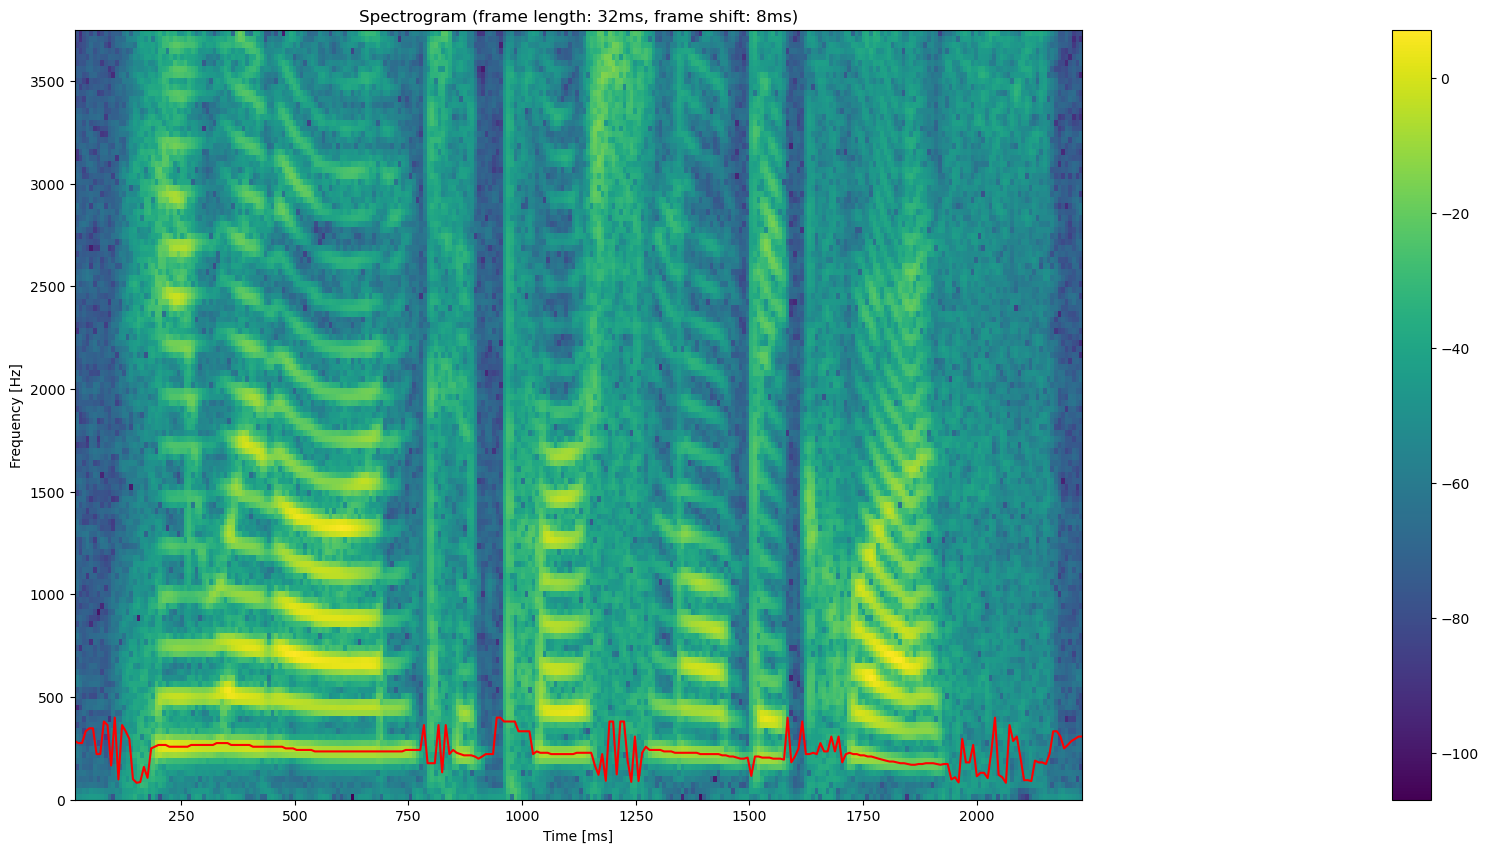

In [202]:
# 2.4.

def estimate_f0(m_frames: np.ndarray, fs: int) -> np.ndarray:
    return np.apply_along_axis(get_fundamental_frequency, 0, x, fs, N, R)


freq_estimate, v_time_frames = estimate_f0(m_frames, fs)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plot_spectrogram(x, fs, N, R, ax=ax, fig=fig)
plt.plot(v_time_frames, freq_estimate, label='Fundamental frequency', color='r')

    
    

2.5

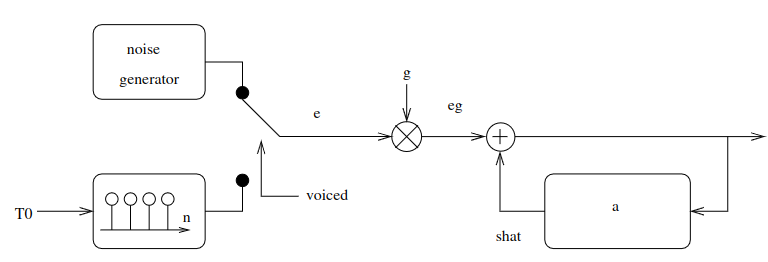

Voiced speech: Impulse train with Fundamental Period T_0
Unvoiced speech: random noise
-> This is our source signal e

After that the gain g ist multiplied (b_0 for the Filter).

Then the recursive Filter is added (a_i coefficients).

In [203]:
# 2.5
from code_exercise3 import compute_LP_coefficients

def compute_lpc(m_frames: np.ndarray, M: int):
    M_lpc = np.apply_along_axis(compute_LP_coefficients, 1, m_frames, M)
    assert M_lpc.shape == (m_frames.shape[0], M)
    return M_lpc

Choose a suitable model order M for linear prediction for a signal with an audio bandwidth of 4 kHz. 
Give reasons for your choice.
-> Slide 193: filter order = sampling frequency +2 , d.h. 8+2 = 10


In [204]:
def get_input_split_size(signal_length, sampling_rate, frame_length, frame_shift):
    frame_length_to_seconds = frame_length / 1000
    frame_length_to_ticks = get_index_from_time(frame_length_to_seconds, sampling_rate)
    frame_shift_to_seconds = frame_shift / 1000
    frame_shift_to_ticks = get_index_from_time(frame_shift_to_seconds, sampling_rate)
    # wir gucken, wie viele frame_shifts in das singal passsen, aber müssen aufpassen, dass es gross genug ist für die frame_length_to_ticks
    return (signal_length - frame_length_to_ticks) // frame_shift_to_ticks + 1

def get_unvoiced_signal(sampels: int):
    return np.random.rand(sampels)

from code_exercise1 import get_period_from_freq
def get_voiced_signal(sampels: int, fs: int, f0 : int =100):
    voiced_ex = np.zeros(sampels)
    voiced_ex[::get_period_from_freq(f0, fs)] = 1
    return voiced_ex

def segment_signal(signal: np.ndarray, R: int) -> np.ndarray:
    frame_shift_samples = convert_to_samples(R, fs)
    splits = np.array_split(signal, len(signal)//frame_shift_samples)
    return splits


segmented_voiced = segment_signal(get_voiced_signal(len(x), fs), R)
segmented_unvoiced = segment_signal(get_unvoiced_signal(len(x)), R)

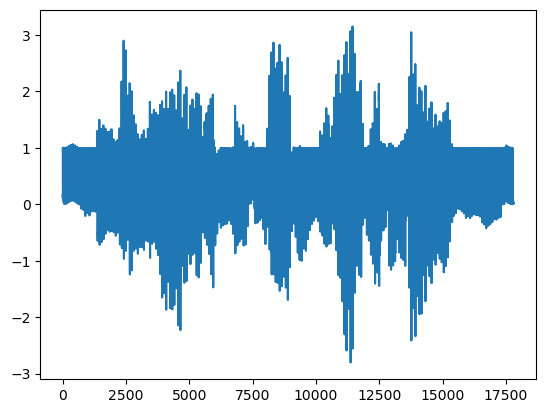

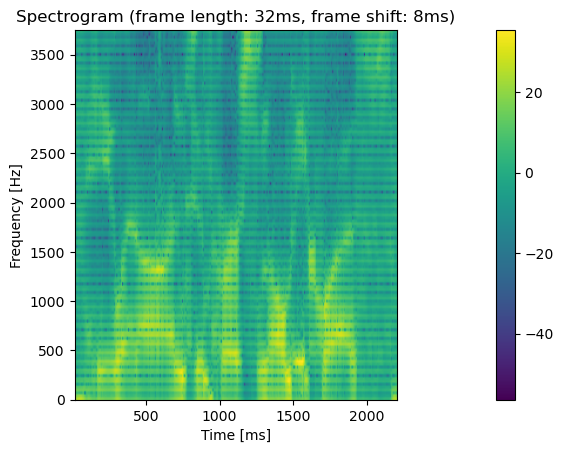

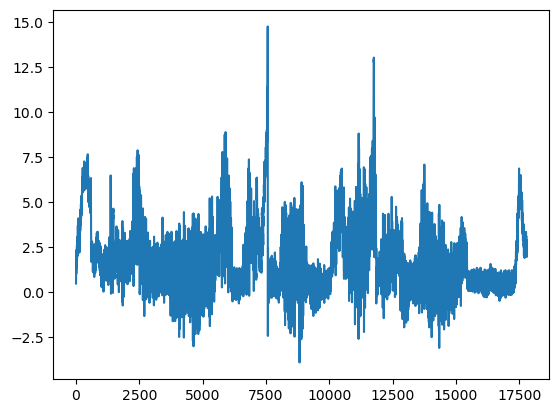

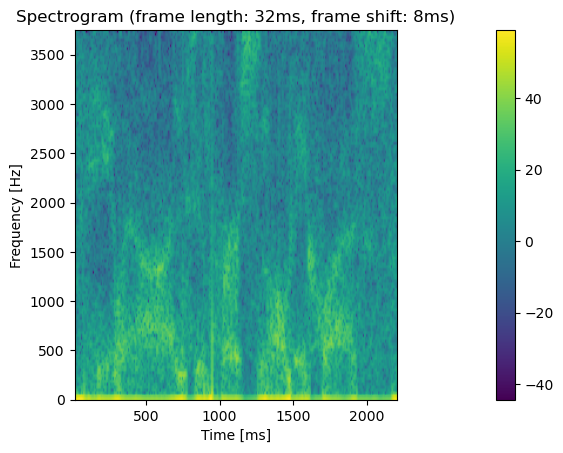

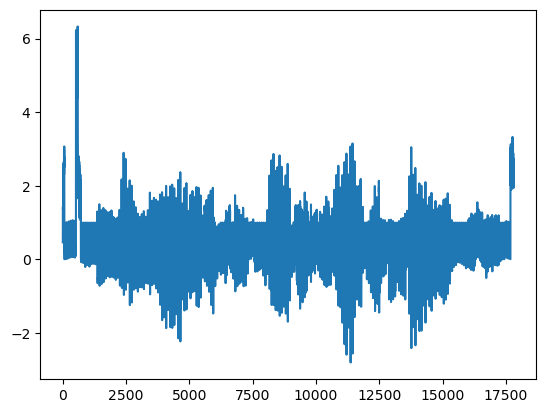

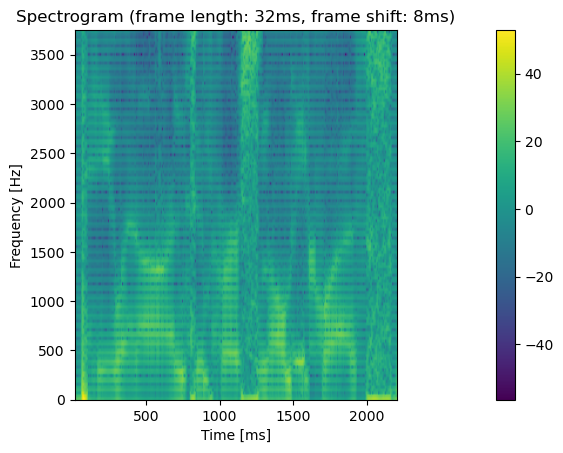

<AxesSubplot:title={'center':'Spectrogram (frame length: 32ms, frame shift: 8ms)'}, xlabel='Time [ms]', ylabel='Frequency [Hz]'>

In [205]:
from UploadCode.filteradaptively import filter_adaptively
from time import sleep
filter_state_voiced = None
filter_state_unvoiced = None

LPCs = compute_lpc(m_frames, 10)
segmented_voiced_output = []
segmented_unvoiced_output = []
segmented_combined_output = []
for i in range(len(LPCs)):
    ar_coeff = np.concatenate(([1], LPCs[i]))
    segment = segmented_voiced[i] #if voiced_decision[i] else segmented_unvoiced[i]
    segment_out, filter_state_voiced = filter_adaptively(np.array([1]), ar_coeff, segment, filter_state_voiced)
    segmented_voiced_output.append(segment_out)
    segment = segmented_unvoiced[i]
    segment_out, filter_state_unvoiced = filter_adaptively(np.array([1]), ar_coeff, segment, filter_state_unvoiced)
    segmented_unvoiced_output.append(segment_out)
    
    if is_voiced(np.array([m_frames[i]])):
        segmented_combined_output.append(segmented_voiced_output[-1])
    else:
        segmented_combined_output.append(segmented_unvoiced_output[-1])
    

segmented_voiced_output = np.concatenate(segmented_voiced_output)
plt.plot(segmented_voiced_output)
#sd.play(segmented_voiced_output, fs)
plot_spectrogram(segmented_voiced_output, fs, 32, R)
#sleep(2)
segmented_unvoiced_output = np.concatenate(segmented_unvoiced_output)
plt.plot(segmented_unvoiced_output)
#sd.play(segmented_unvoiced_output, fs)
plot_spectrogram(segmented_unvoiced_output, fs, 32, R)
#sleep(2)
segmented_combined_output_concat = np.concatenate(segmented_combined_output)
plt.plot(segmented_combined_output_concat)
sd.play(segmented_combined_output_concat, fs)
plot_spectrogram(segmented_combined_output_concat, fs, 32, R)


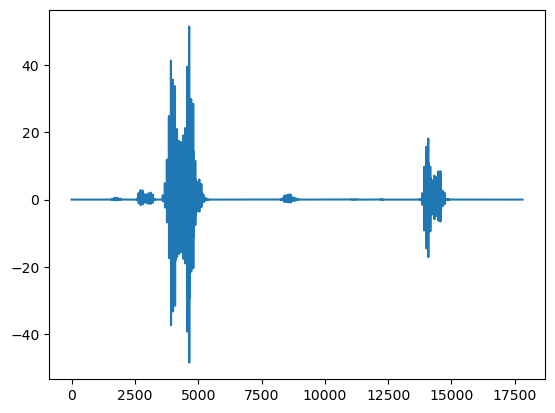

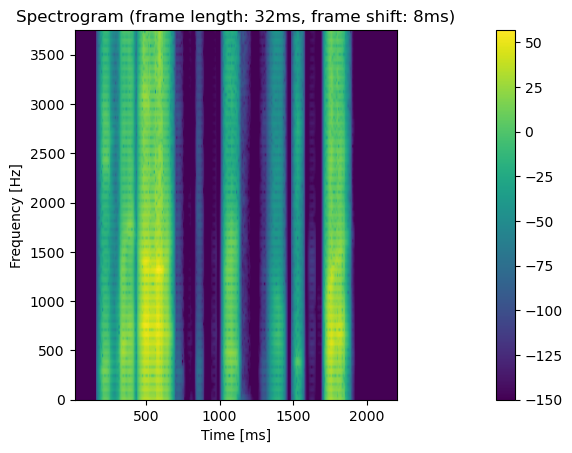

In [209]:
# 3.3
# we have compute power and compute_power_for_all_frames 
gains = compute_power_for_all_frames(m_frames)
segment_gain = compute_power(segmented_combined_output_concat)
#  we want to find x, so that segment*x = gain <=> x = gain/segment
factors = gains/segment_gain
# apply the factors to the segments
segmented_combined_output = [segment * factors[i] for i, segment in enumerate(segmented_combined_output)]
segmented_combined_output_concat = np.concatenate(segmented_combined_output)
plt.plot(segmented_combined_output_concat)
plot_spectrogram(segmented_combined_output_concat, fs, 32, R)
plt.show()
sd.play(segmented_combined_output_concat, fs)
sleep(2)
# What is the improvement? -> noise inbetween gets much lower, so you can hear it more clearly
